In [100]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

In [101]:
data = pd.read_csv("Airline_data.csv")
data

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0
5,1981,21,362,6033.0
6,1982,26,764,5877.0
7,1983,20,809,6223.0
8,1984,16,223,7433.0
9,1985,22,1066,7107.0


In [122]:
upper = 50
lower = 10

n_max = data['Miles flown [100 mln miles]'].max()
n_min = data['Miles flown [100 mln miles]'].min()

theta = (np.log(upper) - np.log(lower)) / (n_max - n_min)
alpha = np.log(lower) - theta * n_min

print(f"theta={theta}\nalpha={alpha}")

theta=0.00045082294465941176
alpha=0.5610560577747383


#### Prior predictive analysis

In [103]:
%%writefile model1.stan

generated quantities {
  real alpha = normal_rng(0.5610560577747383, 0.05);
  real theta = normal_rng(0.00045082294465941176, 0.00015);
  real n = normal_rng(0, 1);
  real lambda = exp(alpha+theta*n);
  int accidents = poisson_rng(lambda);
}

Overwriting model1.stan


In [104]:
# create Stan model object
model = CmdStanModel(stan_file="model1.stan")

R = 1000
sim = model.sample(iter_sampling=R,
                   iter_warmup=0,
                   chains=1,
                   fixed_param=True,
                   seed=1234,
                   refresh=R)


INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab5/model1.stan to exe file /root/Data_Analytics/lab5/model1
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab5/model1
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [105]:
import seaborn as sns
df = sim.draws_pd()
df

,lp__,accept_stat__,alpha,theta,n,lambda,accidents
0,0.0,0.0,0.562698,0.000498,0.536920,1.75587,1.0
1,0.0,0.0,0.546584,0.000400,-0.002657,1.72734,1.0
2,0.0,0.0,0.625845,0.000145,0.992504,1.87009,1.0
3,0.0,0.0,0.547144,0.000637,-1.007600,1.72720,1.0
4,0.0,0.0,0.590065,0.000410,2.847030,1.80621,0.0
...,...,...,...,...,...,...,...
995,0.0,0.0,0.593674,0.000562,-0.104082,1.81052,2.0
996,0.0,0.0,0.596161,0.000419,-0.420557,1.81482,0.0
997,0.0,0.0,0.509105,0.000492,-0.180206,1.66365,0.0
998,0.0,0.0,0.547262,0.000363,-1.634030,1.72749,2.0


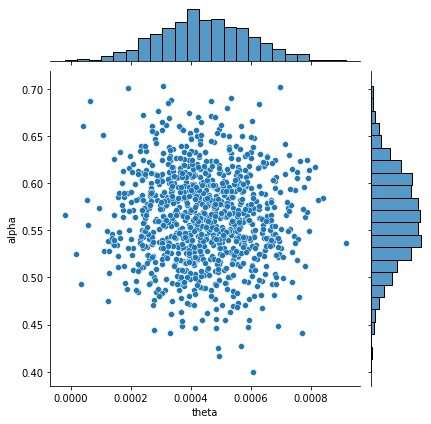

In [106]:
sns.jointplot(df, x='theta', y='alpha')
plt.show()

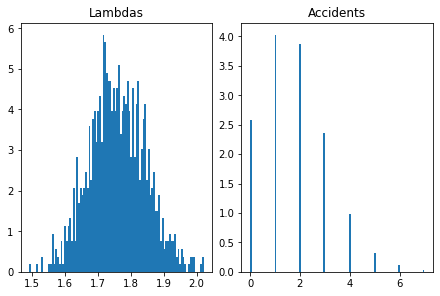

In [107]:
_, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].hist(df['lambda'], density=True, bins=100)
ax[0].set_title("Lambdas")
ax[1].hist(df['accidents'], density=True, bins=100)
ax[1].set_title("Accidents")
plt.show()

#### Fitting the model

In [108]:
%%writefile model2.stan

data {
  int<lower=1> N;
  vector[N] miles;
  int accidents[N];
}

parameters {
  real alpha;
  real theta;
}

transformed parameters {
  real lambda[N];
  for (i in 1:N) {
    lambda[i] = exp(alpha + theta * miles[i]);
  }
}


model {
  alpha ~ normal(0.5610560577747383, 0.05);
  theta ~ normal(0.00045082294465941176, 0.00015);
  
  for (i in 1:N) {
    accidents[i] ~ poisson(lambda[i]);
  }
}

Overwriting model2.stan


In [109]:
# create Stan model object
model = CmdStanModel(stan_file="model2.stan")

R = 1000
fit = model.sample(data={'N': len(data), 'miles': data['Miles flown [100 mln miles]'], 'accidents': data['Fatal accidents']},
                   seed=1234)

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab5/model2.stan to exe file /root/Data_Analytics/lab5/model2
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab5/model2
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/Data_Analytics/lab5/model2.hpp /root/Data_Analytics/lab5/model2.stan
Warning in '/root/Data_Analytics/lab5/model2.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/root/Data_Analytics/lab5/model2.stan', line 14, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g+


INFO:cmdstanpy:CmdStan done processing.


In [110]:
df = fit.draws_pd()
df

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,lambda[1],lambda[2],lambda[3],lambda[4],lambda[5],lambda[6],lambda[7],lambda[8],lambda[9],lambda[10]
0,480.552,0.896722,0.003500,9.0,595.0,0.0,-479.065,0.646567,0.000419,9.64919,11.5903,15.7227,19.0208,21.8720,23.9763,22.4576,25.9652,43.1328,37.6203
1,480.104,0.989540,0.003500,8.0,403.0,0.0,-478.900,0.685993,0.000407,9.56242,11.4233,15.3554,18.4710,21.1512,23.1226,21.7005,24.9811,40.8729,35.7953
2,479.699,0.900461,0.003500,6.0,115.0,0.0,-478.963,0.679295,0.000391,8.94980,10.6197,14.1163,16.8620,19.2100,20.9297,19.6897,22.5459,36.2072,31.8689
3,478.537,0.941716,0.003500,7.0,247.0,0.0,-477.450,0.693028,0.000383,8.79028,10.3931,13.7328,16.3430,18.5678,20.1937,19.0216,21.7191,34.5347,30.4783
4,479.853,0.998062,0.003500,8.0,347.0,0.0,-477.374,0.635639,0.000393,8.62895,10.2473,13.6395,16.3063,18.5883,20.2606,19.0547,21.8328,35.1406,30.9115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,481.170,0.998977,0.003005,8.0,331.0,0.0,-481.000,0.626360,0.000411,9.13630,10.9316,14.7334,17.7520,20.3526,22.2672,20.8859,24.0736,39.5618,34.6061
3996,480.838,0.984131,0.003005,9.0,663.0,0.0,-479.690,0.572217,0.000419,8.93720,10.7323,14.5525,17.6003,20.2346,22.1784,20.7756,24.0155,39.8652,34.7772
3997,480.859,0.997825,0.003005,7.0,155.0,0.0,-480.773,0.573902,0.000418,8.92953,10.7200,14.5288,17.5665,20.1913,22.1278,20.7303,23.9577,39.7375,34.6732
3998,480.565,0.871098,0.003005,2.0,3.0,0.0,-479.622,0.574042,0.000429,9.32230,11.2460,15.3653,18.6717,21.5411,23.6646,22.1317,25.6757,43.1634,37.5263


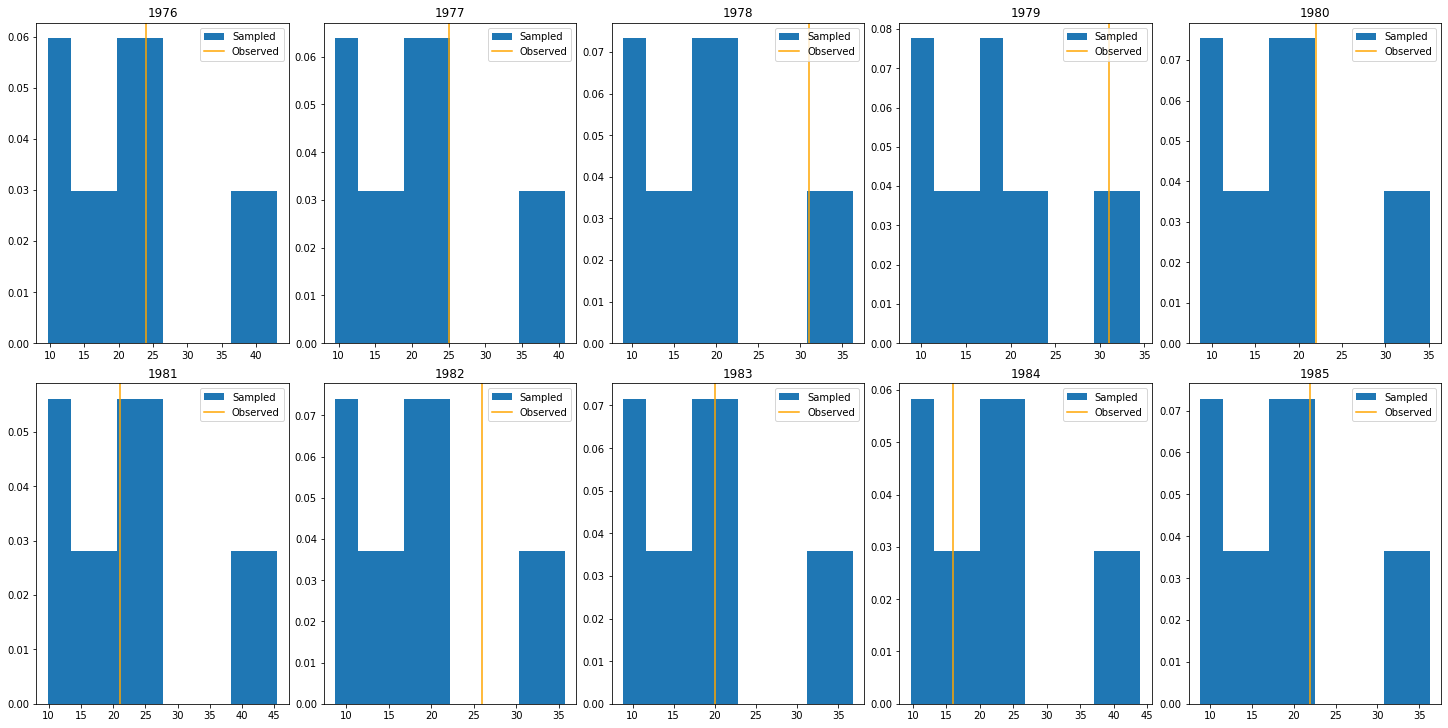

In [121]:
lambdas = df.loc[:, 'lambda[1]':].values

_, ax = plt.subplots(2, 5, constrained_layout=True, figsize=(20, 10))
for ax, sampled_lambda, observed_lambda, year in zip(ax.flatten(), lambdas, data['Fatal accidents'], data['Year']):
    ax.hist(sampled_lambda, density=True, label="Sampled")
    ax.axvline(observed_lambda, label="Observed", color='orange')
    ax.legend()
    ax.set_title(year)

plt.show()